## U-Net segmentation model for Land Use Classification (LUC) using CORINE Level 2 land use classes

In [1]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks import *

In [2]:
cwd = os.getcwd()
path = cwd
#path

In [3]:
path_lbl = '../data/landuse_Level2_bw'
path_img = '../data/sentinel2'

In [4]:
fnames = get_image_files(path_img)
#fnames[:5]

In [5]:
label_names = get_image_files(path_lbl)
#label_names[:5]

In [6]:
codes = np.loadtxt('../data/codes_Level2.txt', dtype=str,delimiter=';')# ; codes

In [7]:
codes

array(['Asustatud alad', 'Tööstus -, äri - ja transport', 'Kaevandus, prügila, ehitus',
       'Kunstlikud, mittepõllumaj. taimestik', 'Põllumaa', 'Püsikultuurid', 'Karjamaad',
       'Heterogeensed põllumaj.-piirkonnad', 'Metsad', 'Võsa ja / või rohttaimest ühend.',
       'Avatud ruumid, vähene taimestik', 'Sisemaal olevad märgalad', 'Mere märgalad', 'Siseveed', 'Mereveed'],
      dtype='<U36')

In [8]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}{x.suffix}'

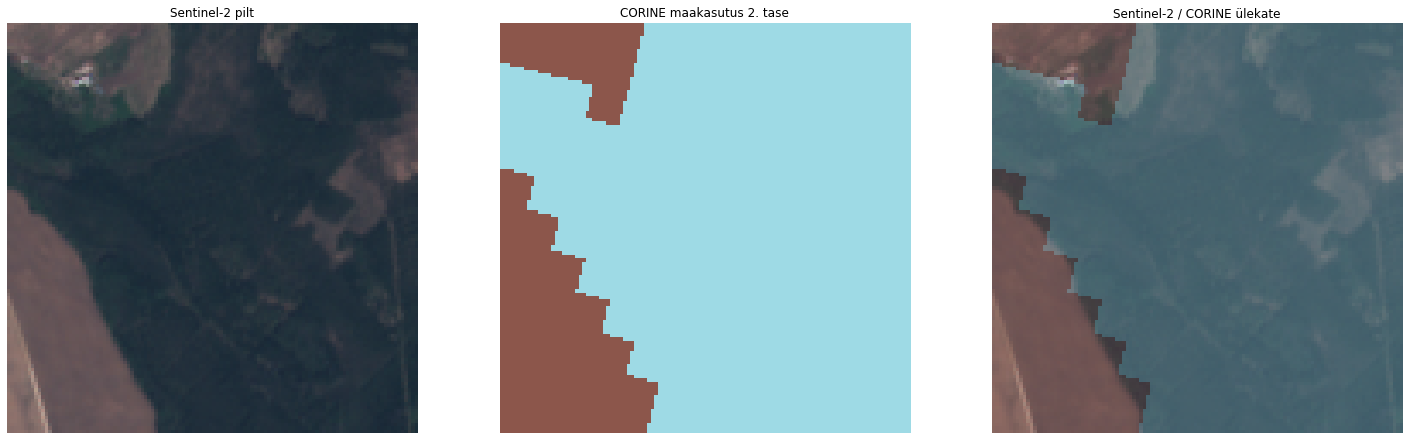

In [9]:
imgfn = fnames[0]
img = open_image(imgfn)
mask = open_mask(get_y_fn(imgfn))

_,axes = plt.subplots(1,3, figsize=(25,15))

img.show(ax=axes[0], title='Sentinel-2 pilt')
mask.show(ax=axes[1], alpha=1, title='CORINE maakasutus 2. tase')
img.show(ax=axes[2], y=mask, alpha=0.3, title='Sentinel-2 / CORINE ülekate')

In [10]:
size = np.array(mask.shape[1:])
bs = 16

In [11]:
src = (SegmentationItemList.from_folder(path_img)  # Load in x data from folder
       .split_by_rand_pct(seed=42)  # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)  # Label data using the get_y_fn function
      )

data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)  # Flip images horizontally and vertically
        .databunch(bs=bs)  # Create a databunch
        .normalize(imagenet_stats)  # Normalize for resnet
       )

In [12]:
def accuracy_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [13]:
learn = unet_learner(data, models.resnet50, metrics=[accuracy_seg],callback_fns=[ShowGraph])

In [23]:
encoder_path = path+'/models/Level2_stage-1-rn50.h5'

In [24]:
learn.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

epoch,train_loss,valid_loss,accuracy_seg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


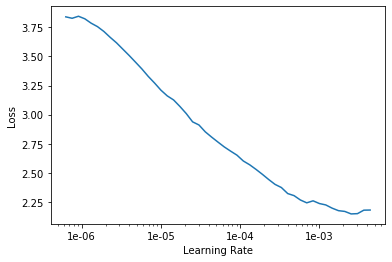

In [18]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_seg,time
0,1.009425,0.979786,0.672465,04:09
1,1.018657,0.824339,0.709469,04:09
2,0.813352,0.823373,0.716502,04:09
3,0.753300,0.742971,0.728331,04:09
4,0.723651,0.702917,0.738215,04:10


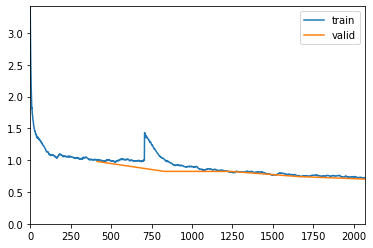

In [25]:
lr=1e-3
learn.fit_one_cycle(5, slice(lr))

In [26]:
learn.save('Level2-unet-stage-1')

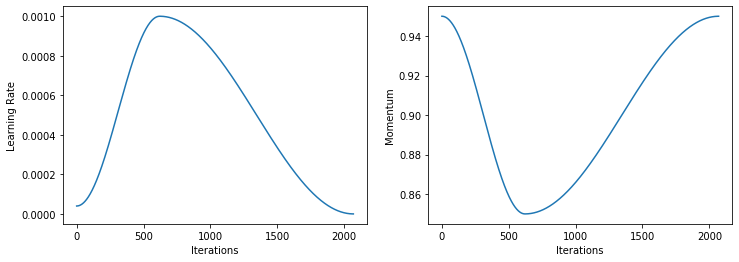

In [27]:
learn.recorder.plot_lr(show_moms=True)

In [14]:
learn.load('Level2-unet-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (6625 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Valid: LabelList (1656 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
     

In [15]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_seg,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


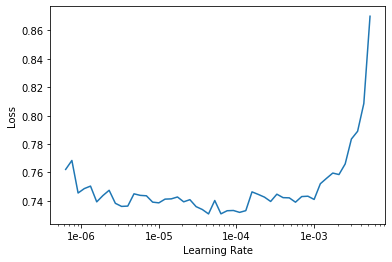

In [29]:
lr_find(learn)
learn.recorder.plot()

In [16]:
lr=5e-4

epoch,train_loss,valid_loss,accuracy_seg,time
0,0.754634,0.705058,0.740553,04:26
1,0.756658,0.728421,0.733746,04:15
2,0.752026,0.720959,0.727481,04:16
3,0.750488,0.709026,0.735889,04:16
4,0.739867,0.689567,0.740990,04:16
5,0.684419,0.677966,0.744600,04:16
6,0.686373,0.664200,0.749054,04:16
7,0.668383,0.646431,0.757475,04:16
8,0.652221,0.640815,0.759522,04:16
9,0.646010,0.641397,0.758408,04:16


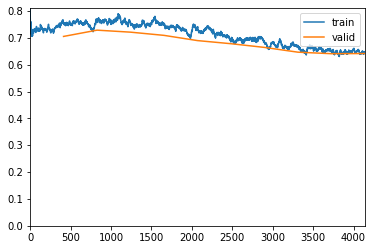

In [17]:
#Trying with 10epochs
learn.fit_one_cycle(10, slice(lr))

In [18]:
learn.save('Level2-unet-stage-2')

In [14]:
learn.load('Level2-unet-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (6625 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Valid: LabelList (1656 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: ../data/sentinel2;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
     

### Analysis

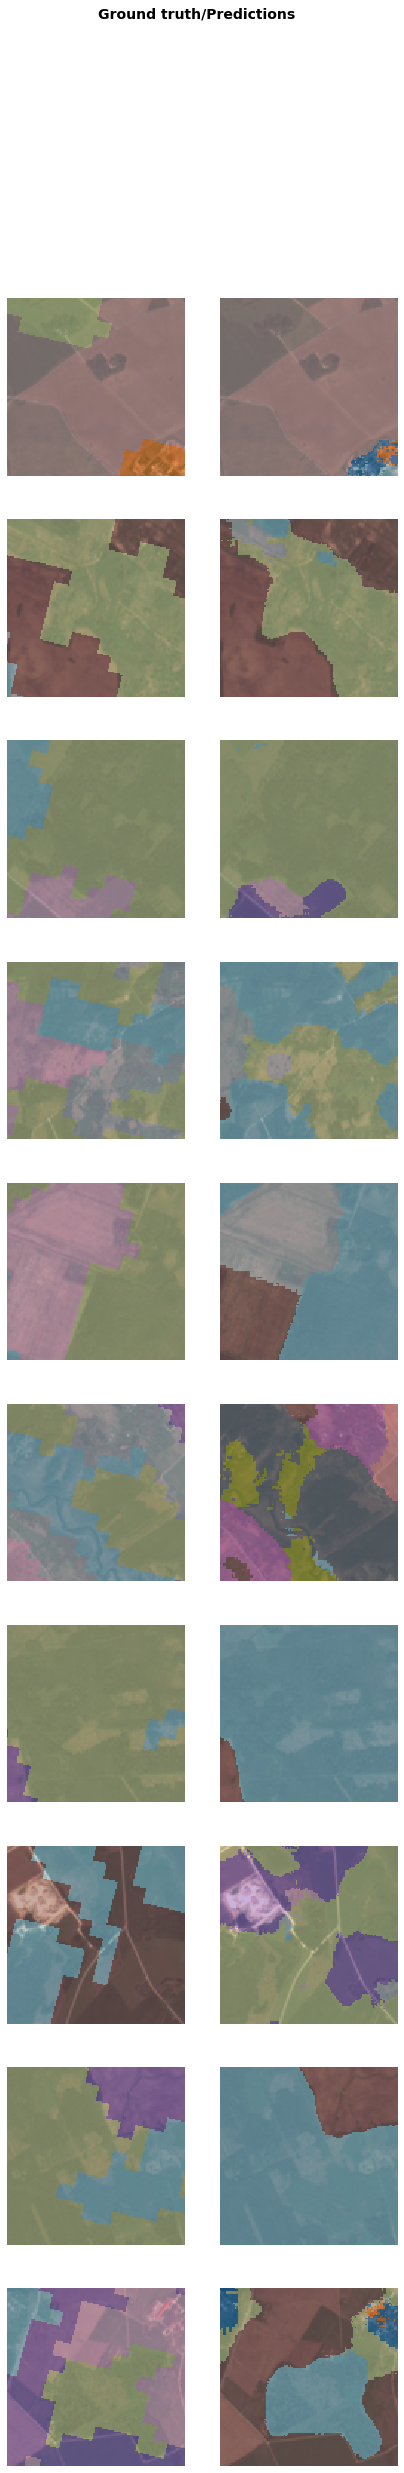

In [22]:
learn.show_results(rows=10, figsize=(7,40))

In [23]:
filenames = data.valid_dl.items

In [24]:
preds = learn.get_preds()

In [25]:
len(preds[0]), len(preds[1])

(1656, 1656)

In [26]:
learn.validate()

[0.64139724, tensor(0.7584)]

In [27]:
valid_df = pd.DataFrame(list(zip(filenames, preds[0].squeeze().tolist(), preds[1].squeeze().tolist())))

In [28]:
valid_df.head()

,0,1,2
0,../data/sentinel2/landusage_est_22_56.png,"[[[0.0018858121475204825, 0.001860030577518046...","[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
1,../data/sentinel2/landusage_est_88_89.png,"[[[0.005124795250594616, 0.004969414789229631,...","[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."
2,../data/sentinel2/landusage_est_48_32.png,"[[[1.0954144272545818e-05, 1.3608985682367347e...","[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
3,../data/sentinel2/landusage_est_09_13.png,"[[[0.0006150861154310405, 0.000561847584322094...","[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
4,../data/sentinel2/landusage_est_18_17.png,"[[[0.00027114187832921743, 0.00023299212625715...","[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."


In [29]:
filenames[0]

PosixPath('../data/sentinel2/landusage_est_22_56.png')

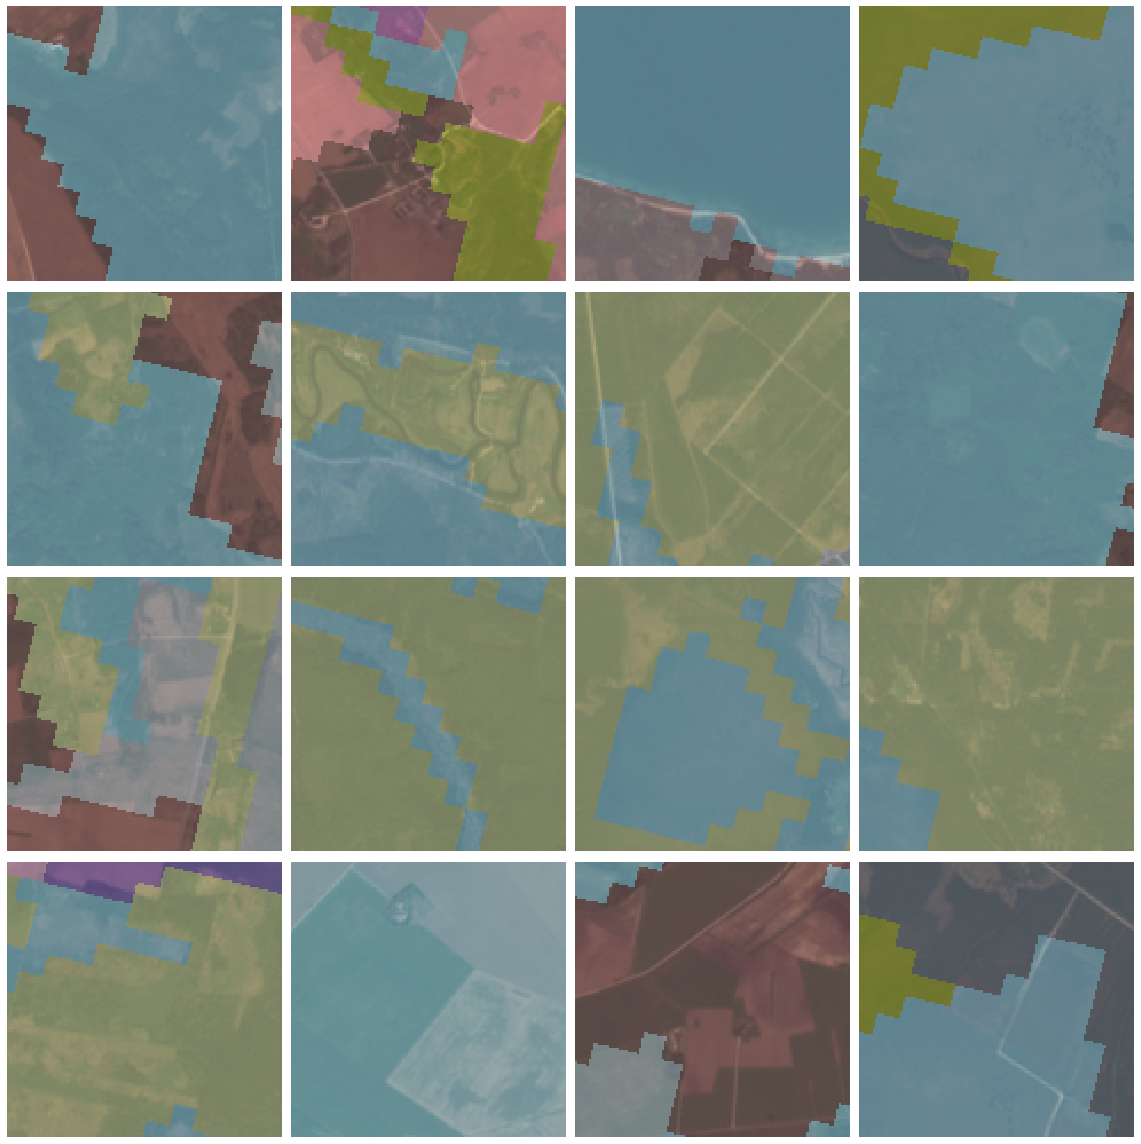

In [30]:
data.show_batch(ds_type=2)

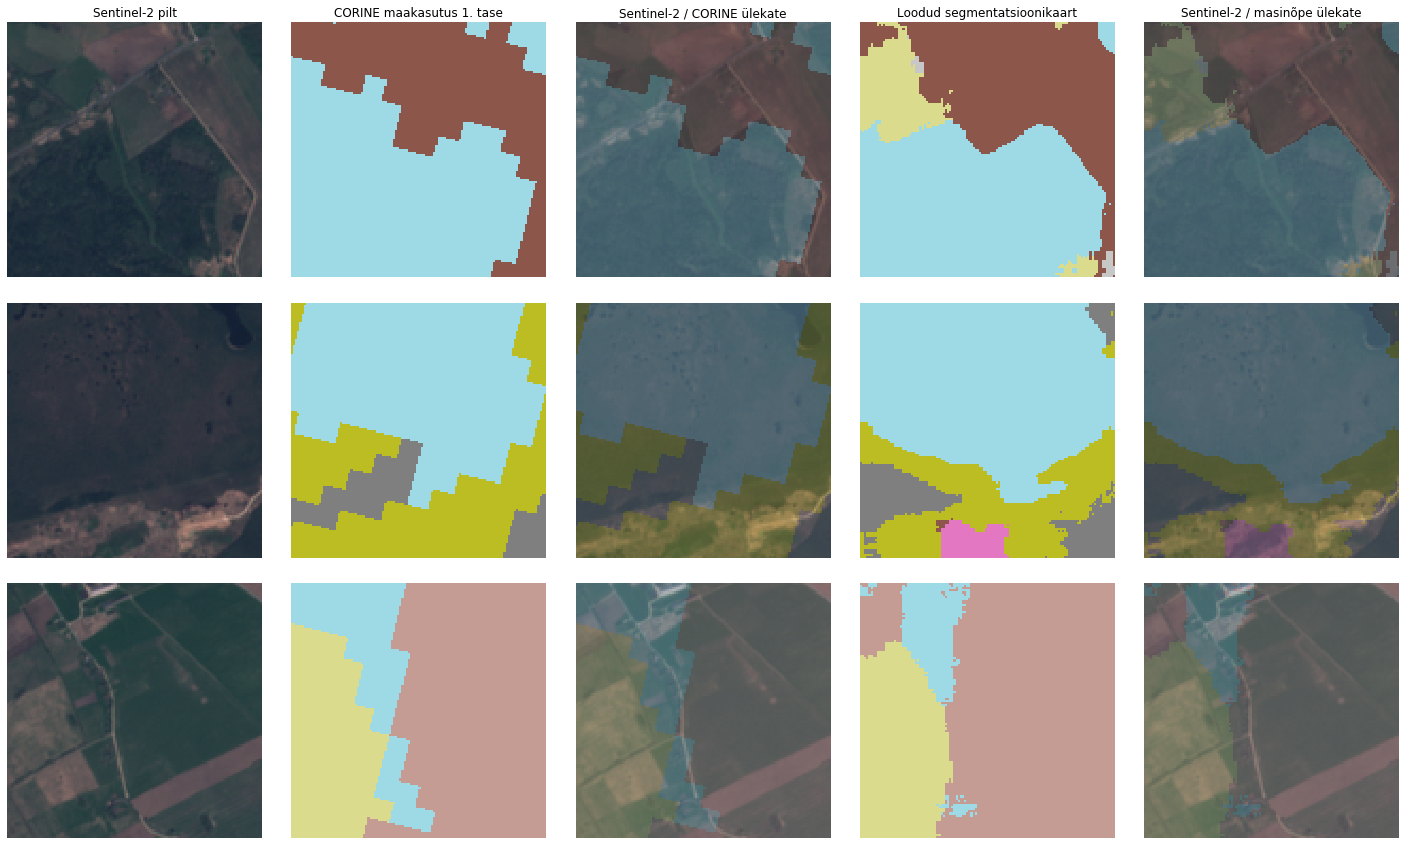

In [22]:
imgfn = fnames[22]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

cols = ['Sentinel-2 pilt','CORINE maakasutus 1. tase','Sentinel-2 / CORINE ülekate','Loodud segmentatsioonikaart','Sentinel-2 / masinõpe ülekate']
_,axes = plt.subplots(3,5, figsize=(25,15))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
img.show(ax=axes[0,0])
mask.show(ax=axes[0,1], alpha=1)
img.show(ax=axes[0,2], y=mask, alpha=0.3)
prediction.show(ax=axes[0,3], alpha=1)
img.show(ax=axes[0,4], y=prediction, alpha=0.3)

imgfn = fnames[20]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[1,0])
mask.show(ax=axes[1,1], alpha=1)
img.show(ax=axes[1,2], y=mask, alpha=0.3)
prediction.show(ax=axes[1,3], alpha=1)
img.show(ax=axes[1,4], y=prediction, alpha=0.3)

imgfn = fnames[21]
img = open_image(imgfn)
prediction = learn.predict(open_image(imgfn))[0]
mask = open_mask(get_y_fn(imgfn))

img.show(ax=axes[2,0])
mask.show(ax=axes[2,1], alpha=1)
img.show(ax=axes[2,2], y=mask, alpha=0.3)
prediction.show(ax=axes[2,3], alpha=1)
img.show(ax=axes[2,4], y=prediction, alpha=0.3)

In [15]:
interp = SegmentationInterpretation.from_learner(learn)

In [16]:
top_losses, top_idxs = interp.top_losses(sizes=(120,120))

In [17]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
Metsad,0.866452
Siseveed,0.804551
Põllumaa,0.75734
Sisemaal olevad märgalad,0.464905
Asustatud alad,0.416278
Mereveed,0.356489
Heterogeensed põllumaj.-piirkonnad,0.297583
Karjamaad,0.281906
"Tööstus -, äri - ja transport",0.178846
Võsa ja / või rohttaimest ühend.,0.156211


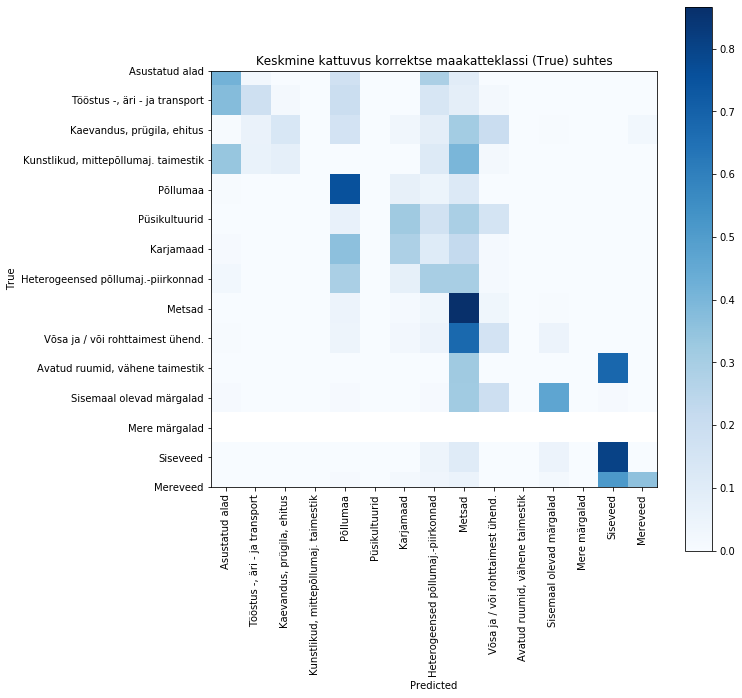

In [18]:
df = interp._plot_intersect_cm(mean_cm, "Keskmine kattuvus korrektse maakatteklassi (True) suhtes")

label,score
Metsad,0.997263
Põllumaa,0.865741
Karjamaad,0
Heterogeensed põllumaj.-piirkonnad,0
Asustatud alad,NaN
"Tööstus -, äri - ja transport",NaN
"Kaevandus, prügila, ehitus",NaN
"Kunstlikud, mittepõllumaj. taimestik",NaN
Püsikultuurid,NaN
Võsa ja / või rohttaimest ühend.,NaN


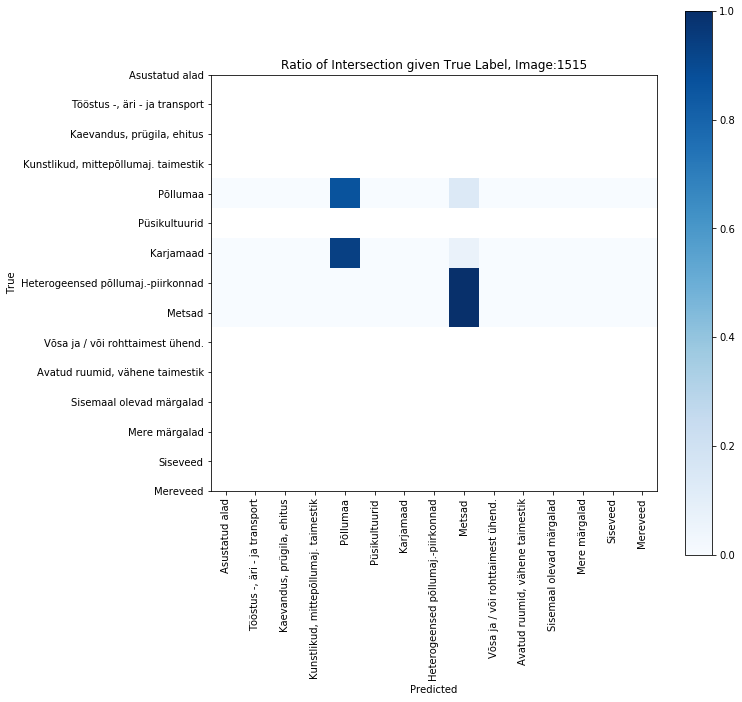

In [19]:
i = top_idxs[-400]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

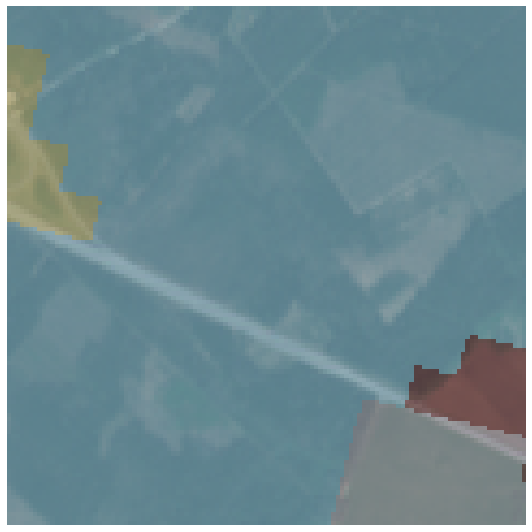

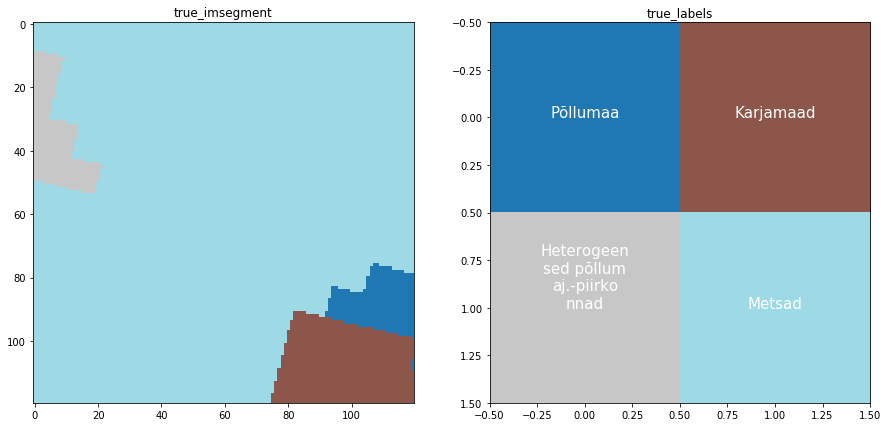

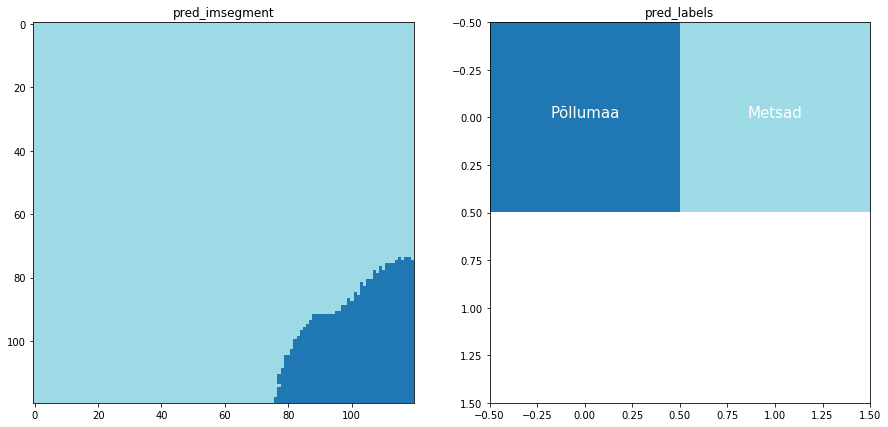

In [20]:
interp.show_xyz(i, sz=15)